In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-darkgrid")

# 1ra Etapa: Análisis exploratorio de los datos

## Tabla Pedidos

Esta tabla contiene los registros históricos de los pedidos realizados por los clientes en una fecha determinada. Aunque los datos no pertenecen a la cadena de suministro actual, nos sirve como base para armar las restricciones de optimización de la misma.

In [591]:
pedidos = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "OrderList")

pedidos.columns = ["Pedido", "Fecha", "Puerto de origen", "Transportista", "TPT", "Nivel de servicio", "Envío adelantado [días]", 
                   "Envío tardío [días]", "Cliente", "Producto", "Planta", "Puerto de destino", "Items", "Peso [kg/item]"]

In [592]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Pedido                   9215 non-null   float64       
 1   Fecha                    9215 non-null   datetime64[ns]
 2   Puerto de origen         9215 non-null   object        
 3   Transportista            9215 non-null   object        
 4   TPT                      9215 non-null   int64         
 5   Nivel de servicio        9215 non-null   object        
 6   Envío adelantado [días]  9215 non-null   int64         
 7   Envío tardío [días]      9215 non-null   int64         
 8   Cliente                  9215 non-null   object        
 9   Producto                 9215 non-null   int64         
 10  Planta                   9215 non-null   object        
 11  Puerto de destino        9215 non-null   object        
 12  Items                    9215 non-

*¿La tabla contiene filas duplicadas?*

In [593]:
pedidos.duplicated().any()

False

In [594]:
pedidos = pedidos.astype({"Pedido": int})
pedidos[["Puerto de origen", "Planta", "Puerto de destino"]] = pedidos[["Puerto de origen", "Planta", 
                                                                        "Puerto de destino"]].replace({"[^\d.]": ""}, regex = True).astype(int)

pedidos.head()

,Pedido,Fecha,Puerto de origen,Transportista,TPT,Nivel de servicio,Envío adelantado [días],Envío tardío [días],Cliente,Producto,Planta,Puerto de destino,Items,Peso [kg/item]
0,1447296446,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,808,14.30
1,1447158014,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,3188,87.94
2,1447138898,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2331,61.20
3,1447363527,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,847,16.16
4,1447363980,2013-05-26,9,V44_3,1,CRF,3,0,V55555_53,1700106,16,9,2163,52.34


*¿Cuántas filas y columnas tiene esta tabla? (N° filas, N° columnas)*

In [595]:
pedidos.shape

(9215, 14)

*¿Cuándo se realizaron los pedidos?*

In [596]:
d = pedidos["Fecha"].unique().astype("datetime64[D]").astype(str)
d[0]

'2013-05-26'

*¿Cuál es el total de pedidos?*

In [597]:
pedidos.shape[0]

9215

*¿Cuántos pedidos fueron solicitados por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [598]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", 
                                      "Puerto de destino"]).agg({"Pedido": "size"}).rename(columns = {"Pedido": "Recuento de Pedidos"})

total = pedidos_agrup["Recuento de Pedidos"].sum()
pedidos_agrup["%"] = pedidos_agrup["Recuento de Pedidos"].apply(lambda x: x / total * 100)

pedidos_agrup.round(2)

,,,Recuento de Pedidos,%
Planta,Puerto de origen,Puerto de destino,,
3,4,9,8541,92.69
4,5,9,1,0.01
8,4,9,102,1.11
9,4,9,12,0.13
12,4,9,300,3.26
13,4,9,86,0.93
16,9,9,173,1.88


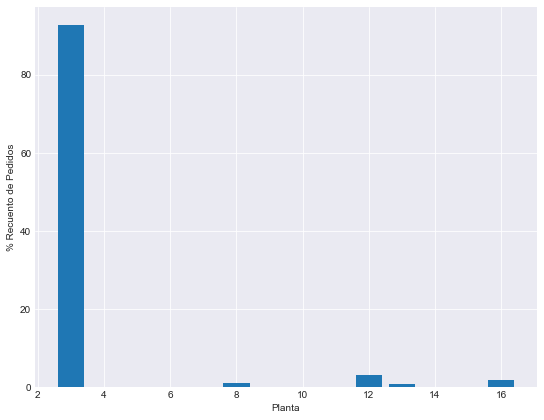

In [599]:
plt.figure(figsize = (9, 7))
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup["%"])
plt.xlabel("Planta")
plt.ylabel("% Recuento de Pedidos");

*¿Cuántos items fueron solicitados por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [600]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Items", "sum")].sum()
pedidos_agrup[("Items", "%")] = pedidos_agrup[("Items", "sum")].apply(lambda x: x / total * 100)

pedidos_agrup.round(2)

Items                              \
                                            min      mean     max       std   
Planta Puerto de origen Puerto de destino                                     
3      4                9                   235   3349.91  561847  16525.97   
4      5                9                   348    348.00     348       NaN   
8      4                9                   684   2715.76    5680   1504.06   
9      4                9                  2301  18652.50  101069  28877.08   
12     4                9                   236    373.33    1321    169.36   
13     4                9                   240    504.41    5244    609.10   
16     9                9                   280   1416.95    4464   1121.49   

                                                            
                                                sum      %  
Planta Puerto de origen Puerto de destino                   
3      4                9                  28611617  96.94  
4      5                9                       348   0.00  
8      4                9                    277008   0.94  
9      4                9                    223830   0.76  
12     4                9                    112000   0.38  
13     4                9                     43379   0.15  
16     9                9                    245133   0.83

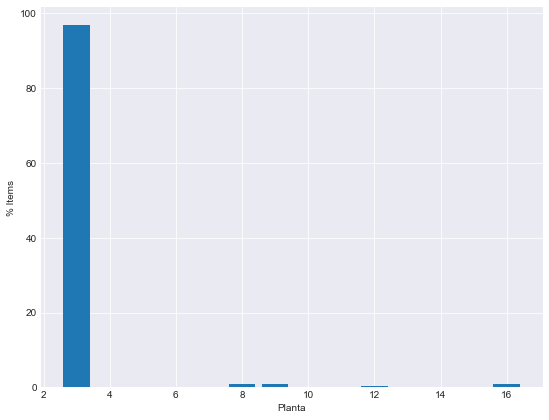

In [601]:
plt.figure(figsize = (9, 7))
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Items", "%")])
plt.xlabel("Planta")
plt.ylabel("% Items");

*Estadística descriptiva de Peso [kg/items] por cada conjunto Planta, Puerto de origen y Puerto de destino*

In [602]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Peso [kg/item]": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Peso [kg/item]", "sum")].sum()
pedidos_agrup[("Peso [kg/item]", "%")] = pedidos_agrup[("Peso [kg/item]", "sum")].apply(lambda x: x / total * 100)

pedidos_agrup.round(2)

Peso [kg/item]                   \
                                                     min    mean      max   
Planta Puerto de origen Puerto de destino                                   
3      4                9                           0.00   15.86  1356.76   
4      5                9                           2.10    2.10     2.10   
8      4                9                           2.29   14.50    43.64   
9      4                9                           5.35   33.86   171.92   
12     4                9                           0.26   27.16   325.96   
13     4                9                           0.35   63.12   946.50   
16     9                9                           0.61  185.94  2338.41   

                                                                     
                                              std        sum      %  
Planta Puerto de origen Puerto de destino                            
3      4                9                   50.20  135486.51  73.99  
4      5                9                     NaN       2.10   0.00  
8      4                9                   10.37    1478.79   0.81  
9      4                9                   48.35     406.36   0.22  
12     4                9                   52.33    8147.43   4.45  
13     4                9                  127.13    5428.39   2.96  
16     9                9                  264.06   32168.01  17.57

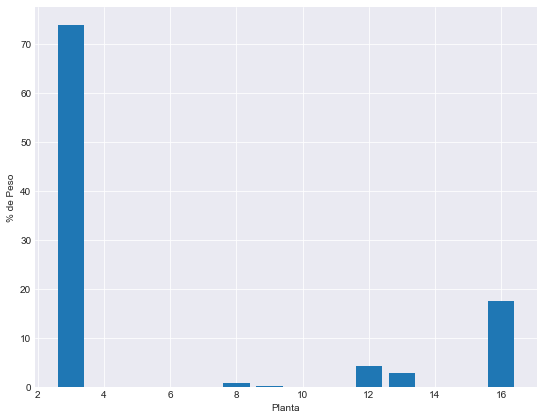

In [603]:
plt.figure(figsize = (9, 7))
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Peso [kg/item]", "%")])
plt.xlabel("Planta")
plt.ylabel("% de Peso");

*¿Hay alguna correlación entre Peso [kg/items] e Items?*

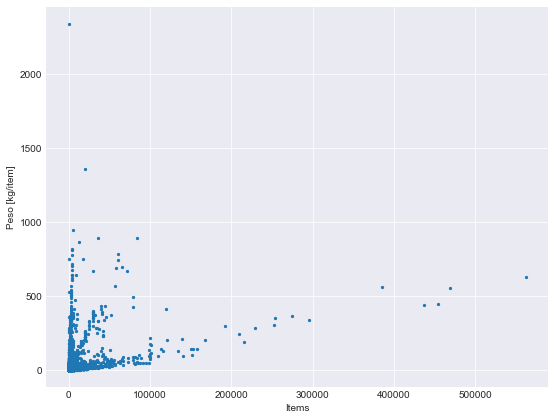

In [604]:
plt.figure(figsize = (9, 7))
plt.scatter(pedidos["Items"], pedidos["Peso [kg/item]"], s = 5)
plt.xlabel("Items")
plt.ylabel("Peso [kg/item]");

In [605]:
from scipy.stats import pearsonr 
r2, pvalue = pearsonr(x = pedidos["Items"], y = pedidos["Peso [kg/item]"])

round(r2, 3)

0.345

## Tabla Fletes

Esta tabla describe todos los transportistas disponibles, los rangos de peso para cada ruta individual y las tarifas asociadas. 

In [606]:
fletes = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "FreightRates")

fletes.columns = ["Transportista", "Puerto de origen", "Puerto de destino", "Peso mínimo [kg/item]", "Peso máximo [kg/item]", 
                  "Nivel de servicio", "Costo mínimo [USD/kg]", "Tasa de flete [USD/kg]", "Modo de transporte", "Envío [días]", 
                  "Tipo de transportista"]

In [607]:
fletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transportista           1540 non-null   object 
 1   Puerto de origen        1540 non-null   object 
 2   Puerto de destino       1540 non-null   object 
 3   Peso mínimo [kg/item]   1540 non-null   float64
 4   Peso máximo [kg/item]   1540 non-null   float64
 5   Nivel de servicio       1540 non-null   object 
 6   Costo mínimo [USD/kg]   1540 non-null   float64
 7   Tasa de flete [USD/kg]  1540 non-null   float64
 8   Modo de transporte      1540 non-null   object 
 9   Envío [días]            1540 non-null   int64  
 10  Tipo de transportista   1540 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 132.5+ KB


*¿La tabla contiene filas duplicadas?*

In [608]:
fletes.duplicated().any()

True

*Si la tabla tiene filas duplicadas, estas deben ser eliminadas.*

In [609]:
fletes.drop_duplicates(inplace = True)

In [610]:
fletes[["Puerto de origen", "Puerto de destino"]] = fletes[["Puerto de origen", 
                                                            "Puerto de destino"]].replace({"[^\d.]": ""}, regex = True).astype(int)
fletes["Modo de transporte"] = fletes["Modo de transporte"].replace({"AIR   ": "Aire", "GROUND": "Tierra"}, regex = True)

fletes.round(2).head()

,Transportista,Puerto de origen,Puerto de destino,Peso mínimo [kg/item],Peso máximo [kg/item],Nivel de servicio,Costo mínimo [USD/kg],Tasa de flete [USD/kg],Modo de transporte,Envío [días],Tipo de transportista
0,V444_6,8,9,250.0,499.99,DTD,43.23,0.71,Aire,2,V88888888_0
1,V444_6,8,9,65.0,69.99,DTD,43.23,0.75,Aire,2,V88888888_0
2,V444_6,8,9,60.0,64.99,DTD,43.23,0.79,Aire,2,V88888888_0
3,V444_6,8,9,50.0,54.99,DTD,43.23,0.83,Aire,2,V88888888_0
4,V444_6,8,9,35.0,39.99,DTD,43.23,1.06,Aire,2,V88888888_0


*¿Cuántas filas y columnas tiene esta tabla?*

In [611]:
fletes.shape

(1537, 11)

*Estadística descriptiva de Tasa de flete [USD/kg] para cada conjunto Puerto de origen y Puerto de destino*

In [612]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Tasa de flete [USD/kg]": ["min", "mean", "max", "std"]})
fletes_agrup.round(2)

Tasa de flete [USD/kg]                     
                                                      min  mean     max    std
Puerto de origen Puerto de destino                                            
2                9                                   0.05  1.87    7.06   1.78
3                9                                   0.12  9.84  128.03  19.98
4                9                                   0.04  1.94    7.66   2.05
5                9                                   0.07  2.87   12.07   2.90
6                9                                   0.07  2.53    7.16   1.74
7                9                                   0.14  0.20    0.28   0.04
8                9                                   0.10  0.59    1.83   0.56
9                9                                   0.03  2.84   21.28   6.59
10               9                                   0.10  5.37   18.96   4.99
11               9                                   0.07  0.13    0.34   0.06

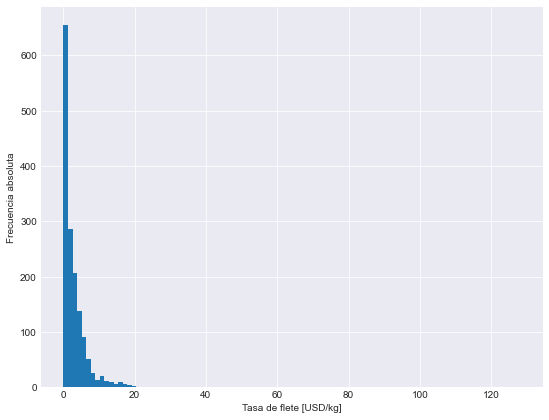

In [613]:
plt.figure(figsize = (9, 7))
plt.hist(fletes["Tasa de flete [USD/kg]"], bins = 100)
plt.xlabel("Tasa de flete [USD/kg]")
plt.ylabel("Frecuencia absoluta");

*Estadística descriptiva de Envío [días] para cada conjunto Puerto de origen y Puerto de destino*

In [614]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Envío [días]": ["min", "mean", "max", "size"]})
fletes_agrup.round(2)

Envío [días]               
                                            min  mean max size
Puerto de origen Puerto de destino                            
2                9                            0  1.62  14  226
3                9                            0  3.05  14   42
4                9                            0  1.58  14  231
5                9                            1  1.27   4  219
6                9                            1  1.99   3  479
7                9                            3  4.50   6   20
8                9                            2  4.82  14   39
9                9                            0  4.42  14   24
10               9                            2  3.17   6  222
11               9                            0  5.29  14   35

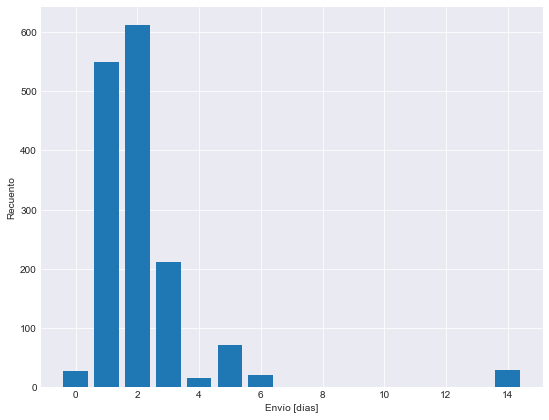

In [615]:
fletes_agrup = fletes.groupby(by = "Envío [días]").agg({"Envío [días]": "size"}).rename(columns = {"Envío [días]": "Recuento"})

plt.figure(figsize = (9, 7))
plt.bar(x = fletes_agrup.index, height = fletes_agrup["Recuento"])
plt.xlabel("Envío [días]")
plt.ylabel("Recuento");

*Estadística descriptiva de Modo de Transporte*

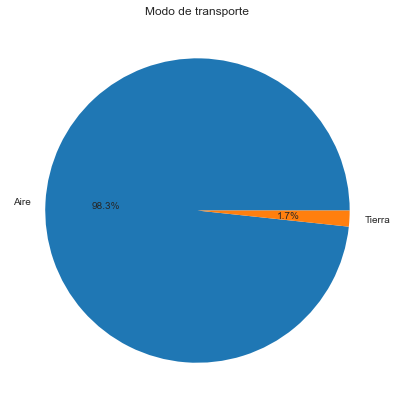

In [616]:
fletes_agrup = fletes.groupby(by = "Modo de transporte").agg({"Puerto de origen": "size"})
fletes_agrup = fletes_agrup.rename(columns = {"Puerto de origen": "Recuento de Puerto de origen"})

plt.figure(figsize = (9, 7))
plt.title("Modo de transporte")
plt.pie(x = fletes_agrup["Recuento de Puerto de origen"], labels = fletes_agrup.index, autopct = "%1.1f%%");

## Tabla Costos de Almacenaje

Esta tabla especifica el costo asociado al almacenamiento de los productos en un almacén determinado medido en dólares por unidad (item).

In [60]:
costos_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCosts")

costos_almacenaje.columns = ["Planta", "Costo específico [USD/item]"]

In [61]:
costos_almacenaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Planta                       19 non-null     object 
 1   Costo específico [USD/item]  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


*¿La tabla contiene filas duplicadas?*

In [62]:
costos_almacenaje.duplicated().any()

False

In [63]:
values = np.arange(1, 16, 1)

In [64]:
costos_almacenaje["Planta"] = costos_almacenaje["Planta"].replace({"[^\d.]": ""}, regex = True).astype(int)
costos_almacenaje = costos_almacenaje.loc[costos_almacenaje["Planta"].isin(values), :]

costos_almacenaje.round(2)

,Planta,Costo específico [USD/item]
0,15,1.42
3,5,0.49
4,2,0.48
5,1,0.57
6,6,0.55
7,10,0.49
8,7,0.37
9,14,0.63
11,12,0.77
12,11,0.56


*Estadística descriptiva de Costo específico [USD/item]*

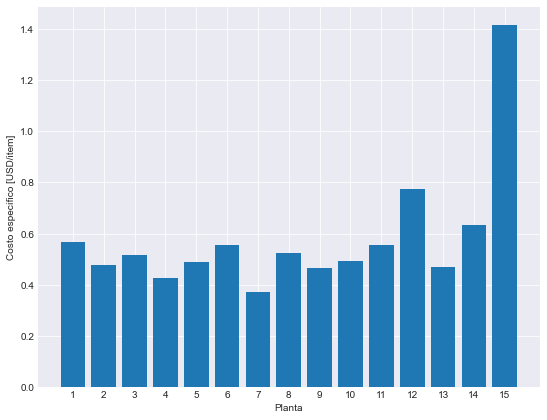

In [65]:
plt.figure(figsize = (9, 7))
plt.bar(x = costos_almacenaje["Planta"], height = costos_almacenaje["Costo específico [USD/item]"])
plt.xlabel("Planta")
plt.xticks(costos_almacenaje["Planta"])
plt.ylabel("Costo específico [USD/item]");

## Tabla Capacidad de Almacenaje

La capacidad de almacenaje es el número máximo de pedidos que se pueden procesar por cada planta, no depende de productos específicos.

In [66]:
capacidad_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCapacities")

capacidad_almacenaje.columns = ["Planta", "Capacidad [pedidos/día]"]

In [67]:
capacidad_almacenaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Planta                   19 non-null     object
 1   Capacidad [pedidos/día]  19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


*¿La tabla contiene filas duplicadas?*

In [68]:
capacidad_almacenaje.duplicated().any()

False

In [69]:
capacidad_almacenaje["Planta"] = capacidad_almacenaje["Planta"].replace({"[^\d.]": ""}, regex = True).astype(int)
capacidad_almacenaje = capacidad_almacenaje.loc[capacidad_almacenaje["Planta"].isin(values), :]

capacidad_almacenaje.round(2)

,Planta,Capacidad [pedidos/día]
0,15,11
3,5,385
4,2,138
5,1,1070
6,6,49
7,10,118
8,7,265
9,14,549
11,12,209
12,11,332


*Estadística descriptiva de Capacidad [items/día]*

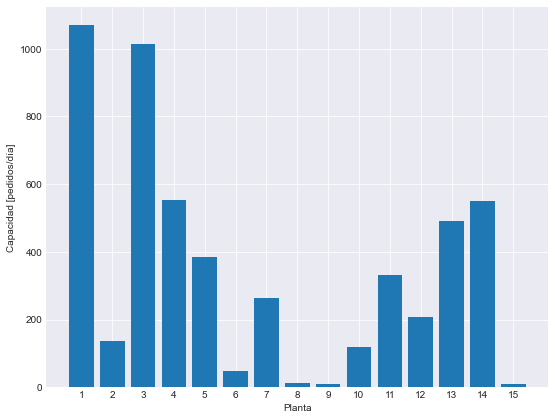

In [70]:
plt.figure(figsize = (9, 7))
plt.bar(x = capacidad_almacenaje["Planta"], height = capacidad_almacenaje["Capacidad [pedidos/día]"])
plt.xlabel("Planta")
plt.xticks(capacidad_almacenaje["Planta"])
plt.ylabel("Capacidad [pedidos/día]");

## Tabla Productos por cada Planta

Esta tabla enumera todas las combinaciones de productos y almacén admitidas.

In [71]:
productos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "ProductsPerPlant")

productos_por_planta.columns = ["Planta", "Producto"]

In [72]:
productos_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Planta    2036 non-null   object
 1   Producto  2036 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.9+ KB


*¿La tabla contiene filas duplicadas?*

In [73]:
productos_por_planta.duplicated().any()

False

In [74]:
productos_por_planta["Planta"] = productos_por_planta["Planta"].replace({"[^\d.]": ""}, regex = True).astype(int)
productos_por_planta = productos_por_planta.loc[productos_por_planta["Planta"].isin(values), :]

productos_por_planta

,Planta,Producto
0,15,1698815
33,5,1650942
34,5,1650946
35,5,1656871
36,5,1656873
...,...,...
2031,4,1699951
2032,4,1699952
2033,4,1699953
2034,4,1699954


*Estadística descriptiva de Recuento de Productos*

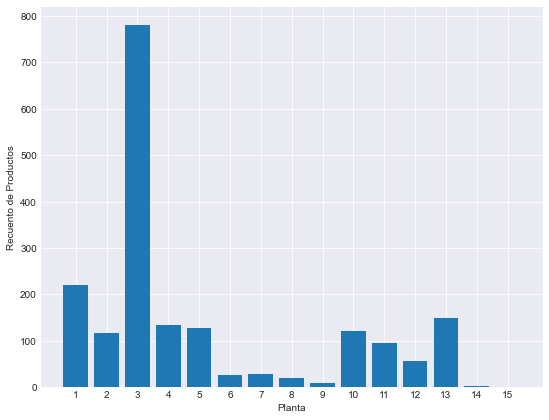

In [75]:
productos_agrup_por_planta = productos_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Productos"})

plt.figure(figsize = (9, 7))
plt.bar(x = productos_agrup_por_planta.index, height = productos_agrup_por_planta["Recuento de Productos"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Productos");

## Tabla Clientes por cada Planta

Esta tabla enumera todos los casos especiales, en los que el almacén solo puede brindar soporte a un cliente específico, mientras que cualquier otro almacén no registrado en la tabla puede abastecer a cualquier cliente.

In [76]:
clientes_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "VmiCustomers")

clientes_por_planta.columns = ["Planta", "Cliente"]

In [77]:
clientes_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Planta   14 non-null     object
 1   Cliente  14 non-null     object
dtypes: object(2)
memory usage: 352.0+ bytes


*¿La tabla contiene filas duplicadas?*

In [78]:
clientes_por_planta.duplicated().any()

False

In [79]:
clientes_por_planta["Planta"] = clientes_por_planta["Planta"].replace({"[^\d.]": ""}, regex = True).astype(int)
clientes_por_planta = clientes_por_planta.loc[clientes_por_planta["Planta"].isin(values), :]

clientes_por_planta

,Planta,Cliente
0,2,V5555555555555_16
1,2,V555555555555555_29
2,2,V555555555_3
3,2,V55555555555555_8
4,2,V55555555_9
5,2,V55555_10
6,2,V55555555_5
7,6,V555555555555555_18
8,6,V55555_10
9,10,V555555555555555_29


In [82]:
def tabla_combinada(X, Y, x, y):
    x = np.repeat(x, y.shape[0], axis = 0)
    y = np.repeat(y, x.shape[1], axis = 1)
    df = pd.DataFrame({X: np.ndarray.flatten(x), Y: np.ndarray.flatten(y)})
    return df

planta = values[~np.isin(values, clientes_por_planta["Planta"])].reshape(1, -1)
clientes = clientes_por_planta["Cliente"].unique().reshape(-1, 1)

df = tabla_combinada("Planta", "Cliente", planta, clientes)

df[:20]

,Planta,Cliente
0,1,V5555555555555_16
1,3,V5555555555555_16
2,4,V5555555555555_16
3,5,V5555555555555_16
4,7,V5555555555555_16
5,8,V5555555555555_16
6,9,V5555555555555_16
7,12,V5555555555555_16
8,13,V5555555555555_16
9,14,V5555555555555_16


In [83]:
clientes_por_planta_ = pd.concat([clientes_por_planta, df]).reset_index(drop = True)

clientes_por_planta_[:20]

,Planta,Cliente
0,2,V5555555555555_16
1,2,V555555555555555_29
2,2,V555555555_3
3,2,V55555555555555_8
4,2,V55555555_9
5,2,V55555_10
6,2,V55555555_5
7,6,V555555555555555_18
8,6,V55555_10
9,10,V555555555555555_29


In [47]:
clientes_agrup_por_planta = clientes_por_planta_.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Clientes"})

clientes_agrup_por_planta

,Recuento de Clientes
Planta,
1,10
2,7
3,10
4,10
5,10
6,2
7,10
8,10
9,10


*Estadística descriptiva de Clientes por cada Planta*

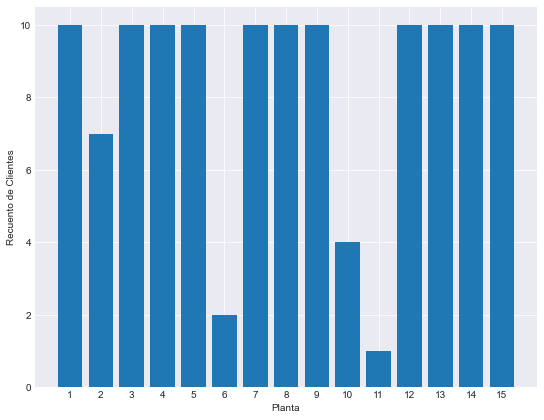

In [84]:
plt.figure(figsize = (9, 7))
plt.bar(x = clientes_agrup_por_planta.index, height = clientes_agrup_por_planta["Recuento de Clientes"])
plt.xlabel("Planta")
plt.xticks(clientes_agrup_por_planta.index)
plt.ylabel("Recuento de Clientes");

## Tabla Puertos por cada Planta

Esta tabla describe las rutas permitidas entre los almacenes y los puertos de envío.

In [89]:
puertos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "PlantPorts").iloc[:, :2]

puertos_por_planta.columns = ["Planta", "Puerto de origen"]

In [90]:
puertos_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Planta            22 non-null     object
 1   Puerto de origen  22 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes


*¿La tabla contiene filas duplicadas?*

In [91]:
puertos_por_planta.duplicated().any()

False

In [92]:
puertos_por_planta[["Planta", "Puerto de origen"]] = puertos_por_planta[["Planta", "Puerto de origen"]].replace({"[^\d.]": ""}, regex = True).astype(int)
puertos_por_planta = puertos_por_planta.loc[puertos_por_planta["Planta"].isin(values), :]

puertos_por_planta

,Planta,Puerto de origen
0,1,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6
6,6,6
7,7,1
8,7,2
9,8,4


In [93]:
planta = values.reshape(1, -1)
puertos_de_origen = np.arange(9, 12, 1).reshape(-1, 1)

df = tabla_combinada("Planta", "Puerto de origen", planta, puertos_de_origen)
df[:20]

,Planta,Puerto de origen
0,1,9
1,2,9
2,3,9
3,4,9
4,5,9
5,6,9
6,7,9
7,8,9
8,9,9
9,10,9


In [94]:
puertos_por_planta_ = pd.concat([puertos_por_planta, df]).reset_index(drop = True)

puertos_por_planta_[:25]

,Planta,Puerto de origen
0,1,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6
6,6,6
7,7,1
8,7,2
9,8,4


In [95]:
puertos_agrup_por_planta = puertos_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Puertos de origen"})

puertos_agrup_por_planta

,Recuento de Puertos de origen
Planta,
1,2
2,1
3,1
4,1
5,1
6,1
7,2
8,1
9,1


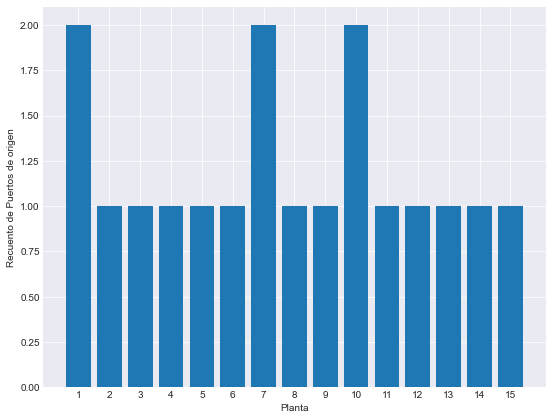

In [96]:
plt.figure(figsize = (9, 7))
plt.bar(x = puertos_agrup_por_planta.index, height = puertos_agrup_por_planta["Recuento de Puertos de origen"])
plt.xlabel("Planta")
plt.xticks(puertos_agrup_por_planta.index)
plt.ylabel("Recuento de Puertos de origen");

# 2da Etapa: Optimización

*Función Objetivo*\
Se desea conocer un conjunto de plantas de almacenaje, puertos de origen y puertos de destino que minimicen el costo total de la cadena de suministro.

Nomenclatura:
- k: ID de pedido
- i: ID de planta de almacenamiento
- p: ID de puerto de origen
- j: ID de puerto de destino
- c: ID de transportista
- s: Nivel de servicio
- t: Tiempo de envío [días]
- m: Modo de transporte (aire o tierra)
- q: Cantidad de items en cada pedido [items]
- w: Peso [kg/item]
- F: Peso máximo [kg/item]

- C: Costo de almacenamiento [USD/item]
- M: Costo fijo de transporte [USD/kg]
- X: Costo de almacenamiento [USD]
- Y: Costo de transporte [USD/kg]
- Z: Costo total de la cadena de suministro [USD]

In [645]:
pedidos = pedidos[["Producto", "Items", "Peso [kg/item]"]].copy()

df1 = pd.merge(pedidos, productos_por_planta, on = "Producto")
df2 = pd.merge(df1, puertos_por_planta_, on = "Planta")
df3 = pd.merge(df2, fletes, on = ["Puerto de origen"])
df4 = pd.merge(df3, costos_almacenaje, on = "Planta")
df5 = pd.merge(df4, capacidad_almacenaje, on = "Planta")
df6 = pd.merge(df5, clientes_por_planta, on = "Planta")

df6.round(2).head()

,Producto,Items,Peso [kg/item],Planta,Puerto de origen,Transportista,Puerto de destino,Peso mínimo [kg/item],Peso máximo [kg/item],Nivel de servicio,Costo mínimo [USD/kg],Tasa de flete [USD/kg],Modo de transporte,Envío [días],Tipo de transportista,Costo específico [USD/item],Capacidad [pedidos/día],Cliente
0,1688629,247,0.18,11,4,V444_8,9,100.0,249.99,DTD,21.47,0.06,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54
1,1688629,247,0.18,11,4,V444_8,9,0.0,99.99,DTD,21.47,0.06,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54
2,1688629,247,0.18,11,4,V444_8,9,500.0,1999.99,DTD,21.47,0.06,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54
3,1688629,247,0.18,11,4,V444_8,9,250.0,499.99,DTD,21.47,0.06,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54
4,1688629,247,0.18,11,4,V444_8,9,2000.0,99999.99,DTD,21.47,0.06,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54


*¿La tabla contiene filas duplicadas?*

In [646]:
df6.duplicated().any()

True

*Si la tabla tiene filas duplicadas, estas deben ser eliminadas.*

In [647]:
df6.drop_duplicates(inplace = True)

*¿Cuántas filas y columnas tiene la nueva tabla? (N° filas, N° columnas)*

In [648]:
df6.shape

(9809031, 18)

*Estadística Descriptiva del Costo de Almacenaje [USD]*

$$ X_{ki} = q_{ki}*C_i $$

In [649]:
df6["Costo de almacenaje [USD]"] = df6["Items"] * df6["Costo específico [USD/item]"]

In [650]:
df6_agrup = df6.groupby(by = ["Planta"]).agg({"Costo de almacenaje [USD]": ["min", "mean", "max", "sum"]})

total = df6_agrup[("Costo de almacenaje [USD]", "sum")].sum()
df6_agrup[("Costo de almacenaje [USD]", "%")] = df6_agrup[("Costo de almacenaje [USD]", "sum")].apply(lambda x: x / total * 100)

df6_agrup.round(2)

Costo de almacenaje [USD]                                      
                             min    mean      max           sum      %
Planta                                                                
2                         112.21  208.14  2934.26  9.727407e+08  41.29
6                         143.51  612.06  5415.10  1.953684e+07   0.83
10                        115.99  273.70  4823.78  1.122336e+09  47.64
11                        130.48  240.67  3411.99  2.413966e+08  10.25

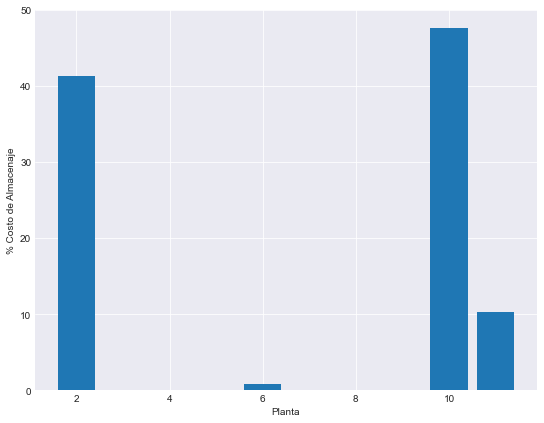

In [651]:
plt.figure(figsize = (9, 7))
plt.bar(x = df6_agrup.index, height = df6_agrup[("Costo de almacenaje [USD]", "%")])
plt.xlabel("Planta")
plt.ylabel("% Costo de Almacenaje");

*Estadística Descriptiva del Costo de Transporte [USD]*

$$ \sum_{k}{w_{kpjcstm}} \leq max \ F_{kpjcstm} $$

In [652]:
df6["Peso [kg]"] = df6["Items"] * df6["Peso [kg/item]"]
df6["Peso máximo [kg]"] = df6["Items"] * df6["Peso máximo [kg/item]"]

In [653]:
df6[["Suma de Peso [kg]", "Máximo del Peso máximo [kg]"]] = df6.groupby(by = ["Puerto de origen", "Puerto de destino", "Transportista", 
    "Modo de transporte", "Envío [días]"])["Peso [kg]", "Peso máximo [kg]"].transform("sum", "max").rename(columns = {"Peso [kg]": "Suma de Peso [kg]", 
    "Peso máximo [kg]": "Máximo del Peso máximo [kg]"})

df6["Suma de Peso real [kg]"] = np.where(df6["Suma de Peso [kg]"] <= df6["Peso máximo [kg]"], df6["Suma de Peso [kg]"], df6["Peso máximo [kg]"])
df6.drop(labels = ["Suma de Peso [kg]", "Máximo del Peso máximo [kg]"], axis = 1, inplace = True)

df6.round(2).head()

<ipython-input-653-4b3f0ad8a6fc>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df6[["Suma de Peso [kg]", "Máximo del Peso máximo [kg]"]] = df6.groupby(by = ["Puerto de origen", "Puerto de destino", "Transportista",


,Producto,Items,Peso [kg/item],Planta,Puerto de origen,Transportista,Puerto de destino,Peso mínimo [kg/item],Peso máximo [kg/item],Nivel de servicio,...,Modo de transporte,Envío [días],Tipo de transportista,Costo específico [USD/item],Capacidad [pedidos/día],Cliente,Costo de almacenaje [USD],Peso [kg],Peso máximo [kg],Suma de Peso real [kg]
0,1688629,247,0.18,11,4,V444_8,9,100.0,249.99,DTD,...,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54,137.15,44.3,61747.53,61747.53
1,1688629,247,0.18,11,4,V444_8,9,0.0,99.99,DTD,...,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54,137.15,44.3,24697.53,24697.53
2,1688629,247,0.18,11,4,V444_8,9,500.0,1999.99,DTD,...,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54,137.15,44.3,493997.53,493997.53
3,1688629,247,0.18,11,4,V444_8,9,250.0,499.99,DTD,...,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54,137.15,44.3,123497.53,123497.53
4,1688629,247,0.18,11,4,V444_8,9,2000.0,99999.99,DTD,...,Aire,14,V88888888_0,0.56,332,V5555555555555555555_54,137.15,44.3,24699997.53,24699997.53


$$ Si \ s = CRF \ \Rightarrow \ Y_{kpjcstm} = 0 $$

$$ Si \ s \neq CRF, \ m = Tierra \ \Rightarrow \ Y_{kpjcstm} = \frac{w_{kpjcstm}}{\sum_{k}{w_{kpjcstm}}}*R_{kpjcstm} $$

$$ Si \ s \neq CRF, \ m \neq Tierra \ \Rightarrow \ Y_{kpjcstm} = w_{kpjcstm}*R_{kpjcstm} $$

$$ Si \ Y_{kpjcstm} < M_{kpjcstm} \ \Rightarrow \ Y_{kpjcstm} = M_{kpjcstm} $$

In [654]:
a = df6["Peso [kg]"] / df6["Suma de Peso real [kg]"] * df6["Tasa de flete [USD/kg]"]
b = df6["Peso [kg]"] * df6["Tasa de flete [USD/kg]"]
c = df6["Costo mínimo [USD/kg]"]

df6["Costo de transporte [USD]"] = np.where(df6["Nivel de servicio"] == "CRF", 0, 
                                            np.where(df6["Modo de transporte"] == "Tierra", np.where(a > c, a, c),
                                                    np.where(b > c, b, c)))

df6_agrup = df6.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Costo de transporte [USD]": ["min", "mean", "max", "sum"]})

total = df6_agrup[("Costo de transporte [USD]", "sum")].sum()
df6_agrup[("Costo de transporte [USD]", "%")] = df6_agrup[("Costo de transporte [USD]", "sum")].apply(lambda x: x / total * 100)

df6_agrup.round(2)

Costo de transporte [USD]            \
                                                         min      mean   
Puerto de origen Puerto de destino                                       
2                9                                      1.79  29393.24   
3                9                                     19.36   1893.88   
4                9                                      1.50  26166.77   
6                9                                      2.81  38625.71   
9                9                                     17.69    606.37   
10               9                                      2.50  79736.28   
11               9                                      7.83   2001.61   

                                                                      
                                            max           sum      %  
Puerto de origen Puerto de destino                                    
2                9                  17952919.93  5.372755e+10  10.65  
3                9                   1046541.73  1.150906e+09   0.23  
4                9                  19486627.34  1.184122e+10   2.35  
6                9                   1625612.09  7.770720e+08   0.15  
9                9                    149505.96  3.573915e+08   0.07  
10               9                  48215810.46  4.347123e+11  86.20  
11               9                    876694.82  1.720440e+09   0.34

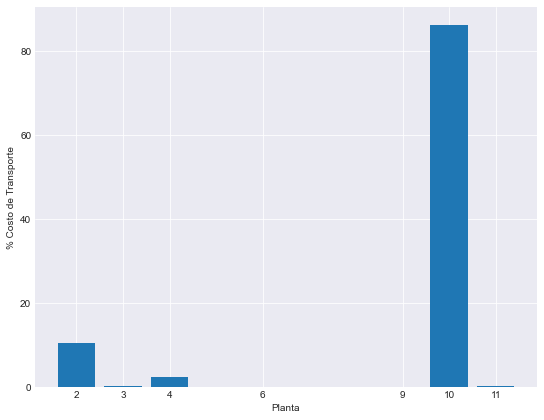

In [655]:
plt.figure(figsize = (9, 7))
plt.bar(x = df6_agrup.index.levels[0], height = df6_agrup[("Costo de transporte [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df6_agrup.index.levels[0])
plt.ylabel("% Costo de Transporte");

*Estadística Descriptiva del Costo Total [USD]*

$$ Z_{ipj} = min \sum_{k}{(X_{ki} + Y_{kpj})} $$

In [656]:
#df6["Costo total [USD]"] = df6["Costo de almacenaje [USD]"] + df6["Costo de transporte [USD]"]
#df6_agrup = df6.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo total [USD]": ["min", "mean", "max", "sum"]})

#total = df6_agrup[("Costo total [USD]", "sum")].sum()
#df6_agrup[("Costo total [USD]", "%")] = df6_agrup[("Costo total [USD]", "sum")].apply(lambda x: x / total * 100)

#df6_agrup.round(2)

In [657]:
#plt.figure(figsize = (9, 7))
#plt.bar(x = df6_agrup.index.levels[0], height = df6_agrup[("Costo total [USD]", "%")])
#plt.xlabel("Planta")
#plt.xticks(df6_agrup.index.levels[0])
#plt.ylabel("% Costo total");